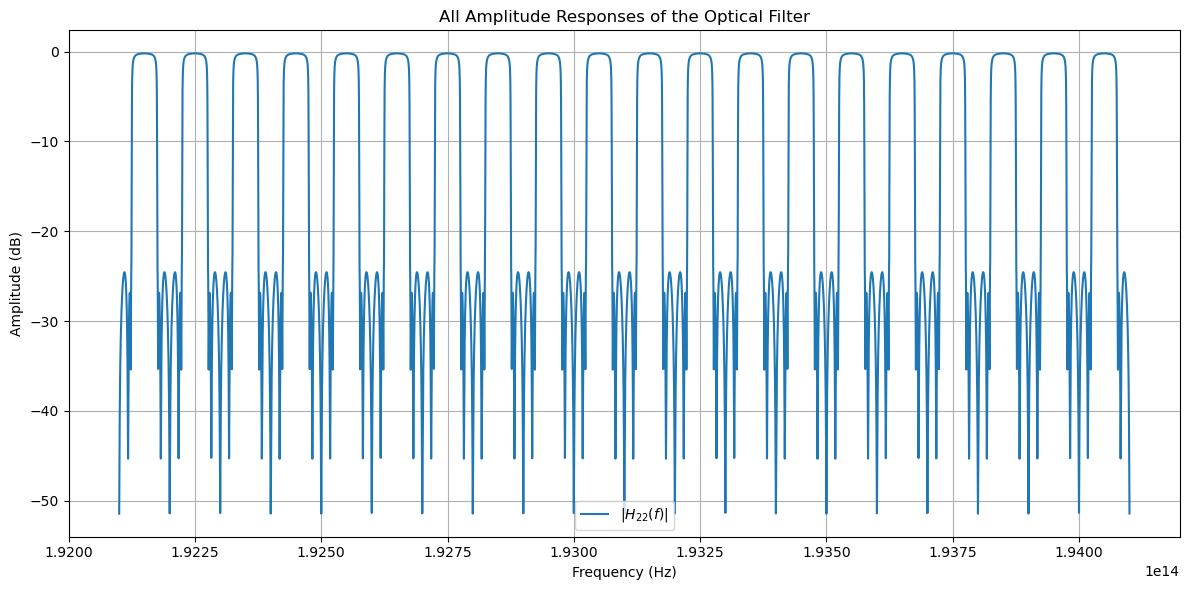

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 基础参数
kr = 0.5
kl = 0.5
k1 = 0.8673
k2 = 0.09
k3 = 0.393

phi1 = 0.5 * 2 * np.pi
phi2 = 0.5 * 2 * np.pi
phi3 = 0.5 * 2 * np.pi
phid = 0
t = 0.979888
fFSR = 100e9  # 100 GHz
s = 10

# 定义耦合矩阵
j = 1j
H1 = np.array([[np.sqrt(1 - kr), -j * np.sqrt(kr)],
               [-j * np.sqrt(kr), np.sqrt(1 - kr)]])

H3 = np.array([[np.sqrt(1 - kl), -j * np.sqrt(kl)],
               [-j * np.sqrt(kl), np.sqrt(1 - kl)]])

# 频率向量初始化
w1 = -20 * np.pi
w2 = 20 * np.pi
dw = 0.006285
w_range = np.arange(w1, w2, dw)
len_w = len(w_range)

# 定义 Au(w) 和 Al(w)
def Au(w):
    e = np.exp(-j * w)
    term1 = (np.sqrt(1 - k1) - t**2 * e**2 * np.exp(-j * phi1)) / (1 - np.sqrt(1 - k1) * t**2 * e**2 * np.exp(-j * phi1))
    term2 = (np.sqrt(1 - k2) - t**2 * e**2 * np.exp(-j * phi2)) / (1 - np.sqrt(1 - k2) * t**2 * e**2 * np.exp(-j * phi2))
    return term1 * term2

def Al(w):
    e = np.exp(-j * w)
    term = (np.sqrt(1 - k3) - t**2 * e**2 * np.exp(-j * phi3)) / (1 - np.sqrt(1 - k3) * t**2 * e**2 * np.exp(-j * phi3))
    return term * t * e * np.exp(-j * phid)

# 初始化输出
H11 = np.zeros(len_w, dtype=complex)
H12 = np.zeros(len_w, dtype=complex)
H21 = np.zeros(len_w, dtype=complex)
H22 = np.zeros(len_w, dtype=complex)

# 主循环
for i, w in enumerate(w_range):
    H2 = np.array([[Au(w), 0],
                   [0, Al(w)]])
    H = H1 @ H2 @ H3
    H11[i] = H[0, 0]
    H12[i] = H[0, 1]
    H21[i] = H[1, 0]
    H22[i] = H[1, 1]

# 频率向量对应光学频率（单位：Hz）
frequency_f = np.linspace(193.1e12 - s * fFSR, 193.1e12 + s * fFSR, len_w)

# 幅度响应 (dB)
amplitude_H11 = 20 * np.log10(np.abs(H11))
amplitude_H12 = 20 * np.log10(np.abs(H12))
amplitude_H21 = 20 * np.log10(np.abs(H21))
amplitude_H22 = 20 * np.log10(np.abs(H22))

# 绘图
plt.figure(figsize=(12, 6))
#plt.plot(frequency_f, amplitude_H11, label=r'$|H_{11}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H12, label=r'$|H_{12}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H21, label=r'$|H_{21}(f)|$', linewidth=1.5)
plt.plot(frequency_f, amplitude_H22, label=r'$|H_{22}(f)|$', linewidth=1.5)

plt.title('All Amplitude Responses of the Optical Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

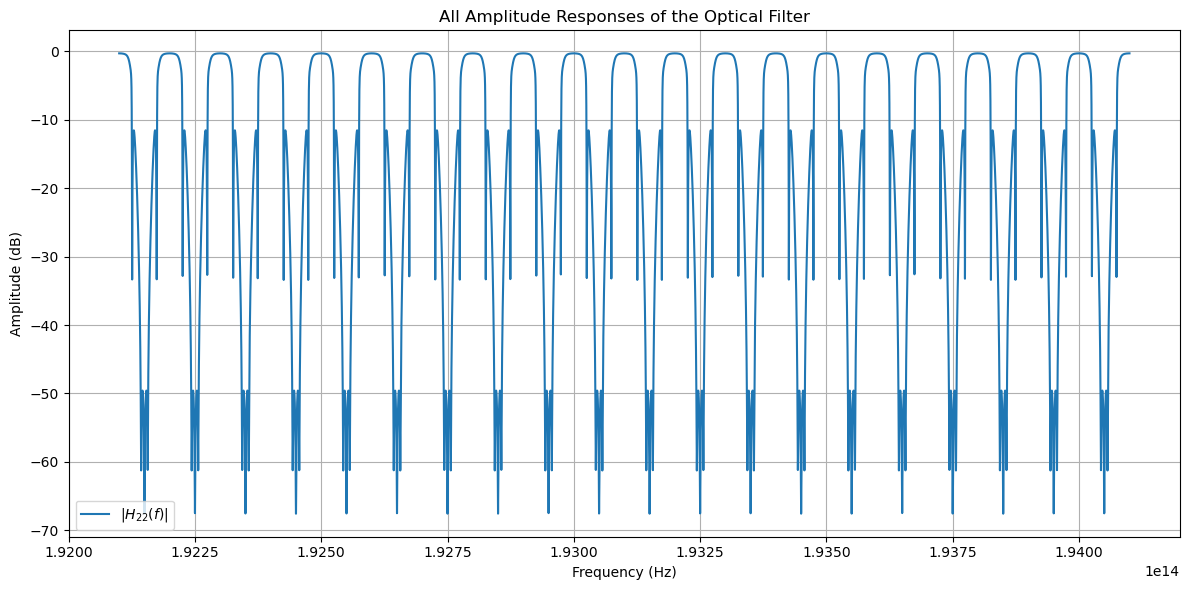

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def tunable_mzi_in(theta_i):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_i), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def tunable_mzi_out(theta_o):
    j = 1j
    coupler_50_50 = 0.5 * np.array([[-1+j, 1+j], [1+j, -1+j]])
    phase_matrix = np.array([[np.exp(-j * theta_o), 0], [0, 1]])
    return coupler_50_50 @ phase_matrix @ coupler_50_50

def phase_shifter_matrix(phi_t, phi_b):
    j = 1j
    return np.array([[np.exp(-j * phi_t), 0], [0, np.exp(-j * phi_b)]])

def mrr_transfer_function(w, t, k, phi_offset):
    j = 1j
    numerator = np.sqrt(1 - k) - t**2 * np.exp(-j * (2*w + phi_offset))
    denominator = 1 - t**2 * np.sqrt(1 - k) * np.exp(-j * (2*w + phi_offset))
    return numerator / denominator

def delay_line(w, t, delay, phi_c):
    j = 1j
    return t * np.exp(-j * w * delay - j * phi_c)


f_center = 193.1e12  # 中心频率 (Hz)
FSR = 100e9          # 自由光谱范围 (Hz), 100 GHz

theta_i = np.pi / 2
theta_o = np.pi / 2

phi_t = 0.0
phi_b = 0.0 

Hi = tunable_mzi_in(theta_i)
Hp = phase_shifter_matrix(phi_t, phi_b)

H1 = Hi @ Hp

H3 = tunable_mzi_out(theta_o)

Au = lambda w: mrr_transfer_function(w, t=0.98, k=0.86, phi_offset=np.pi) * mrr_transfer_function(w, t=0.98, k=0.09, phi_offset=np.pi) * mrr_transfer_function(w, t=0.98, k=0.69, phi_offset=np.pi)
Al = lambda w: mrr_transfer_function(w, t=0.98, k=0.39, phi_offset=np.pi) * mrr_transfer_function(w, t=0.98, k=0.48, phi_offset=np.pi) * delay_line(w, t=0.98, delay=1.0, phi_c=0.0)

H2 = np.array([[Au, 0],
                [0, Al]])

w1 = -20 * np.pi
w2 = 20 * np.pi
dw = 0.006285
w_range = np.arange(w1, w2, dw)
len_w = len(w_range)

s=10

H11 = np.zeros(len_w, dtype=complex)
H12 = np.zeros(len_w, dtype=complex)
H21 = np.zeros(len_w, dtype=complex)
H22 = np.zeros(len_w, dtype=complex)

# 主循环
for i, w in enumerate(w_range):
    H2 = np.array([[Au(w), 0],
                   [0, Al(w)]])
    H = H1 @ H2 @ H3
    H11[i] = H[0, 0]
    H12[i] = H[0, 1]
    H21[i] = H[1, 0]
    H22[i] = H[1, 1]

# 频率向量对应光学频率（单位：Hz）
frequency_f = np.linspace(f_center - s * FSR, f_center + s * FSR, len_w)

# 幅度响应 (dB)
amplitude_H11 = 20 * np.log10(np.abs(H11))
amplitude_H12 = 20 * np.log10(np.abs(H12))
amplitude_H21 = 20 * np.log10(np.abs(H21))
amplitude_H22 = 20 * np.log10(np.abs(H22))

# 绘图
plt.figure(figsize=(12, 6))
#plt.plot(frequency_f, amplitude_H11, label=r'$|H_{11}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H12, label=r'$|H_{12}(f)|$', linewidth=1.5)
#plt.plot(frequency_f, amplitude_H21, label=r'$|H_{21}(f)|$', linewidth=1.5)
plt.plot(frequency_f, amplitude_H22, label=r'$|H_{22}(f)|$', linewidth=1.5)

plt.title('All Amplitude Responses of the Optical Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

